## Imports and Helper Functions

In [1]:
import pandas as pd
import mplleaflet
import mapclassify
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import numpy as np

# Replace any number of spaces with just a single space
def refineSpaces(x):
    return x.replace('\s+', ' ', regex=True)

# Remove leading and trailing white space
def removeExcessWhitespace(x):
    return x.str.strip()

# Convert the string to uppercase
def toUpper(x):
    return x.str.upper()


## Define what data you want

In [16]:
censusDataPath = 'data/csv/census/nyc-median-income-2015.csv' # path to the census data you want to analyze
censusDataColumn = 'Median income (dollars); Estimate; Households' # column in the census data set to zone and color on the map

violationDataPath = 'data/csv/ParkingViolations/nyc-parking-violations-partial-2015.csv'

legendTitle = 'Median Household Income, Thousands of USD'
mapTitle = 'NYC Median Household Income vs Parking Violations - 2015'

imageName = 'generated/median-income-2015.png'
htmlName = 'generated/median-income-2015.html'


## Data Cleaning

In [17]:
violations = pd.read_csv(violationDataPath)
violations[['House Number', 'Street Name']] = violations[['House Number', 'Street Name']].apply(refineSpaces)
violations[['House Number', 'Street Name']] = violations[['House Number', 'Street Name']].apply(removeExcessWhitespace)
violations[['House Number', 'Street Name']] = violations[['House Number', 'Street Name']].apply(toUpper)

openmaps = pd.read_csv('data/csv/nyc-address-to-zip-code.csv')
openmaps[['NUMBER', 'STREET']] = openmaps[['NUMBER', 'STREET']].apply(refineSpaces)
openmaps[['NUMBER', 'STREET']] = openmaps[['NUMBER', 'STREET']].apply(removeExcessWhitespace)
openmaps[['NUMBER', 'STREET']] = openmaps[['NUMBER', 'STREET']].apply(toUpper)

# read in shape data and turn zcta(zip code) into an int
shapes = gpd.read_file('data/shp/nyc-shape-by-zip')
shapes['zcta'] = shapes['zcta'].astype(int)

# read in census data and ensure that rows have numeric data
censusData = pd.read_csv(censusDataPath)
censusData = censusData[pd.to_numeric(censusData[censusDataColumn], errors='coerce').notnull()]

print("Done cleaning data.")


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Done cleaning data.


# Merge our dataframes together

In [18]:
# merge in zip code based on address
merged = pd.merge(violations, openmaps,  how='inner', left_on=['House Number','Street Name'], right_on = ['NUMBER','STREET'])
print(merged.shape)

# merge in shapefile stuff on zip code
merged = pd.merge(merged, shapes, how='inner', left_on=['POSTCODE'], right_on=['zcta'])

# merge in census data based on zip code
merged = pd.merge(merged, censusData[['Id2', censusDataColumn]], how='inner', left_on=['POSTCODE'], right_on=['Id2'])

merged.to_csv("generated/nyc-merged-data-all.csv")

print("Done merging data frames.")


(20659, 55)
Done merging data frames.


# Plot violations and zip codes, then color

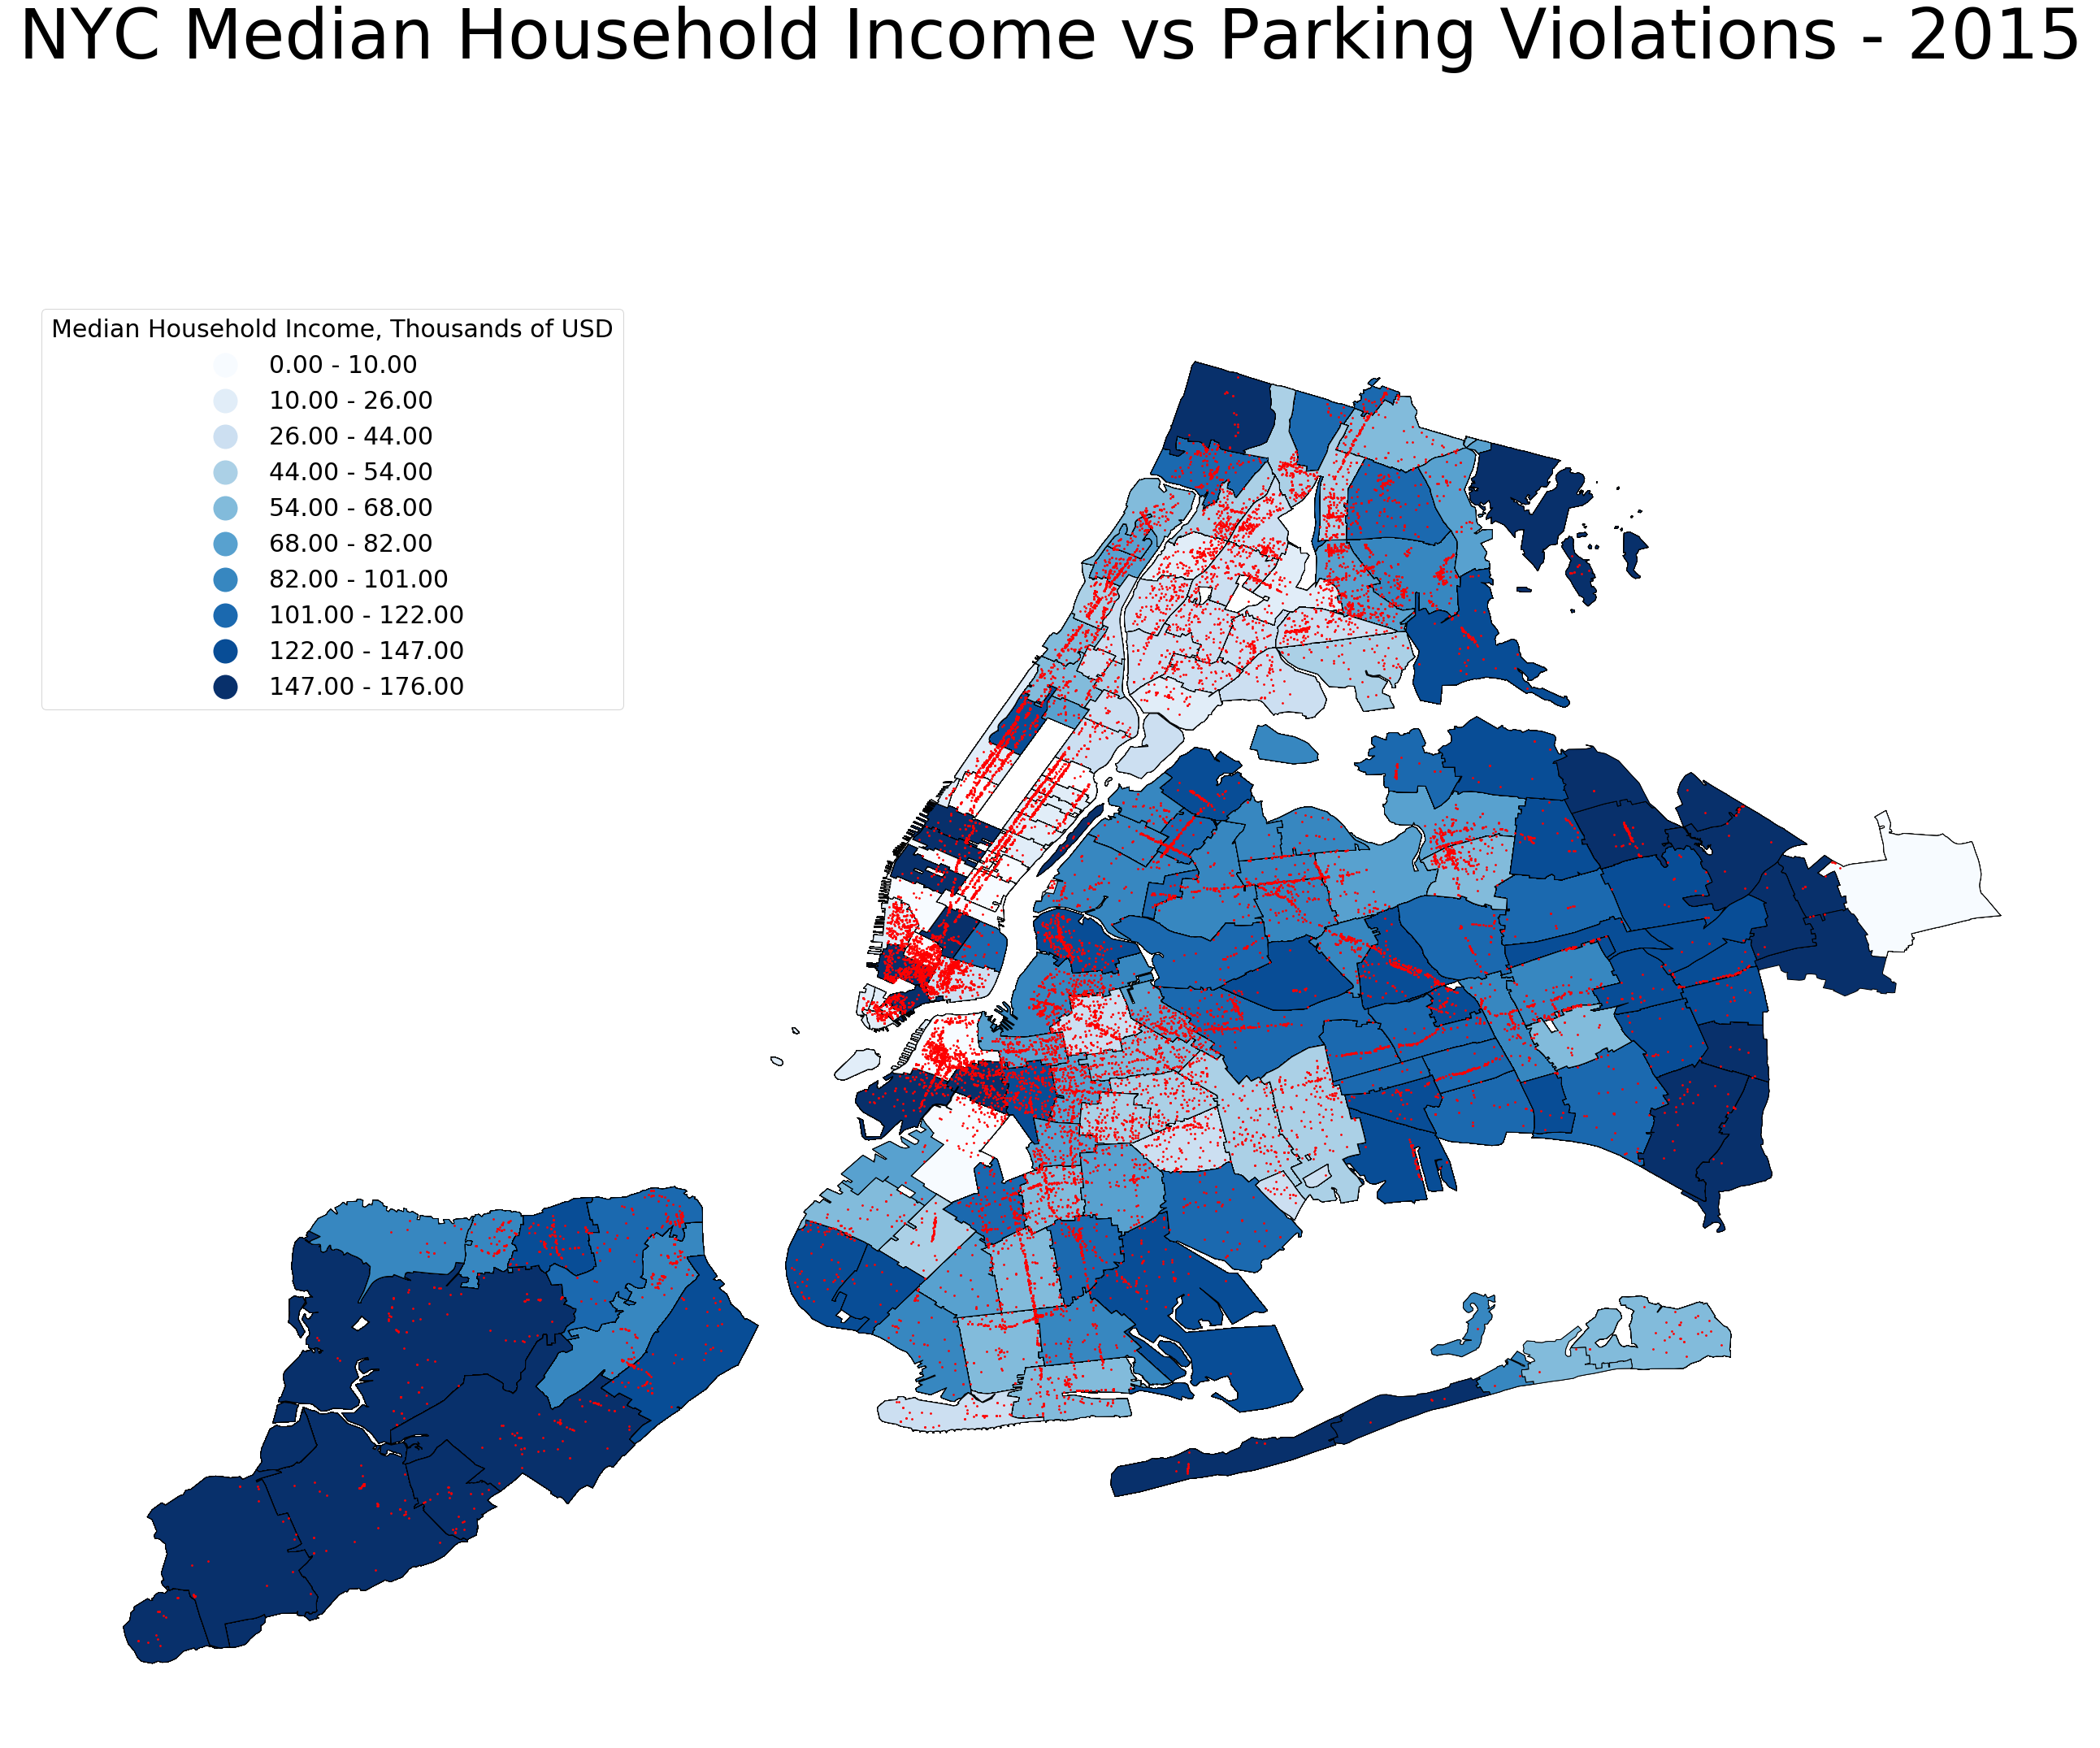

In [19]:
# legend cannot be shown to mplleaflet. comment out the first one if youre plotting to mflleaflet
ax = GeoDataFrame(merged).plot(column=censusDataColumn,  cmap='Blues', scheme='QUANTILES', k=10, figsize=(36, 36), edgecolor='black', legend=True, legend_kwds={'title': legendTitle, 'loc': 'upper left', 'title_fontsize':30, 'markerscale': 3, 'prop': {'size': 30}})
#ax = GeoDataFrame(merged).plot(column=censusDataColumn,  cmap='Blues', scheme='QUANTILES', k=10, figsize=(36, 36), edgecolor='black')

ax = plt.scatter(merged['LON'], merged['LAT'], marker='o', s=3, color="red")

plt.axis('off')

figure = ax.figure
figure.suptitle(mapTitle, fontsize=85)
figure.tight_layout()
figure.subplots_adjust(top=1.0)

figure.savefig(imageName, dpi=150)
plt.show()
#mplleaflet.save_html(fig=figure, fileobj=htmlName)
